## Imports

In [286]:
import os
import sys
import time
import h5py
import logging

import qutip             as qt
import numpy             as np
import matplotlib.pyplot as plt

from quantum_control_rl_server.remote_env_tools import Client
# add quantum-control-rl dir to path for subsequent imports
#sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

logger           = logging.getLogger('RL')
logger.propagate = False
logger.handlers  = []
stream_handler   = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)
logger.setLevel(logging.INFO)



In [287]:
def H1_coeff(t,args):
    omega_pulse = (np.pi)/args['t_pulse']
    pulse = args['amp']*(np.cos(omega_pulse*t)**2)
    pulse = pulse + 1j*(args['drag']/(2*args['kerr']))*args['amp']*omega_pulse*np.sin(2*omega_pulse*t)
    return pulse

def H2_coeff(t,args):
    omega_pulse = (np.pi)/args['t_pulse']
    pulse = args['amp']*(np.cos(omega_pulse*t)**2)
    pulse = pulse - 1j*(args['drag']/(2*args['kerr']))*args['amp']*omega_pulse*np.sin(2*omega_pulse*t)
    return pulse

def pi_pulse_sim(   amp,          # amp of cos^2 pulse in GHz
                    drag,         # dimensionless drag param
                    detuning,     # detuning of pi pulse in GHz
                    t_pulse = 10, # duration of pi pulse in ns
                    N = 5,        # number of transmon states
                    kerr = -0.1,  # kerr nonlinearity of transmon in GHz
                    n_times = 101 # number of time-steps for the qutip simulation
                    ):

    tp   = 2*np.pi
    rt   = np.sqrt
    q    = qt.destroy(N)
    num  = q.dag()*q
    psi0 = qt.fock(N,0)
    psif = qt.fock(N,1)

    # frequencies in GHz, times in ns
    ts    = np.linspace(-t_pulse/2, t_pulse/2, n_times)
    T1    = 10e3 #ns
    k1    = 1./T1
    T2    = 5e3 #ns
    k_phi = (1./T2) - k1/2.
    c_ops = [rt(k1)*q, rt(k_phi)*num] 

    args  = {   'amp':amp,
                't_pulse':t_pulse,
                'drag':drag,
                'kerr':kerr
                }
    H0    = - detuning * q.dag() * q
    H0   += kerr * (num**2 - num)
    H0   *= tp
    H1    = q.dag()
    H2    = q

    # Full Hamiltonian
    H           = [H0,[H1,H1_coeff],[H2,H2_coeff]]
    # Full simulation
    result      = qt.mesolve(H,psi0,tlist=ts,args=args, c_ops=c_ops)
    # Calculate a reward for the agent
    this_reward = qt.expect(qt.ket2dm(psif), result.states[-1]) # return reward as pauli measurement
    this_reward = 2*this_reward - 1.
    return result, this_reward

In [289]:
client_socket = Client()
(host, port) = '127.0.0.1', 5555 # ip address of RL server, here it's hosted locally
client_socket.connect((host, port))

# training loop
done = False
while not done:

    # receive action data from the agent (see tf_env -> reward_remote())
    message, done = client_socket.recv_data()
    logger.info('Received message from RL agent server.')
    logger.info('Time stamp: %f' %time.time())

    if done:
        logger.info('Training finished.')
        break

    # parsing message (see tf_env -> reward_remote())
    action_batch = message['action_batch']
    batch_size   = message['batch_size']
    epoch_type   = message['epoch_type']
    epoch        = message['epoch']

    # parsing action_batch and reshaping to get rid of nested
    # structure [[float_param]] required by tensorflow
    amplitudes   = action_batch['amp'].reshape([batch_size])
    drags        = action_batch['drag'].reshape([batch_size])
    detunings    = action_batch['detuning'].reshape([batch_size])

    logger.info('Start %s epoch %d' %(epoch_type, epoch))

    # collecting rewards for each policy in the batch
    reward_data  = np.zeros((batch_size))
    for ii in range(batch_size):

        # evaluating reward for ii'th element of the batch
        #   - can perform different operations depending on the epoch type
        #     for example, using more averaging for eval epochs
        if epoch_type == 'evaluation':
            _, reward_data[ii] = pi_pulse_sim2(amplitudes[ii] ,drags[ii],detunings[ii])
        elif epoch_type == 'training':
            _, reward_data[ii] = pi_pulse_sim2(amplitudes[ii] ,drags[ii],detunings[ii])
        
    # Print mean and stdev of reward for monitoring progress
    R     = np.mean(reward_data) 
    std_R = np.std(reward_data)
    logger.info('Average reward %.3f' %R)
    logger.info('STDev reward %.3f' %std_R)
    
    # send reward data back to server (see tf_env -> reward_remote())
    logger.info('Sending message to RL agent server.')
    logger.info('Time stamp: %f' %time.time())
    client_socket.send_data(reward_data)

Received message from RL agent server.
Time stamp: 1684360311.523663
Start evaluation epoch 0
Average reward -0.270
STDev reward 0.000
Sending message to RL agent server.
Time stamp: 1684360311.543654
Received message from RL agent server.
Time stamp: 1684360311.925991
Start training epoch 0
Average reward -0.305
STDev reward 0.179
Sending message to RL agent server.
Time stamp: 1684360312.659886
Received message from RL agent server.
Time stamp: 1684360332.204414
Start training epoch 1
Average reward -0.111
STDev reward 0.183
Sending message to RL agent server.
Time stamp: 1684360332.963184
Received message from RL agent server.
Time stamp: 1684360333.031272
Start training epoch 2
Average reward -0.006
STDev reward 0.167
Sending message to RL agent server.
Time stamp: 1684360333.758036
Received message from RL agent server.
Time stamp: 1684360333.913094
Start training epoch 3
Average reward 0.121
STDev reward 0.192
Sending message to RL agent server.
Time stamp: 1684360334.625309
Rece

In [290]:
# Get the results of training 
root_dir = os.getcwd()
filename = root_dir+r'\20230517.h5'
key      = '18'
with h5py.File(filename,'r') as f :
    print(f.keys())
    rl_params        = {key:item for key,item in f[key]['rl_params'].attrs.items()}
    training_actions = {key:item[()] for key,item in f[key]['training']['actions'].items()}
    epochs           = np.arange(rl_params['num_epochs'])
    training_rewards = f[key]['training']['rewards'][()]

<KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9']>


In [291]:
# Calculate infidelity and its std deviation
infidelity       = (1-training_rewards)/2.0
mean_infidelity  = np.mean(infidelity,axis=1)
stdev_infidelity = np.std(infidelity,axis=1)
min_infidelity   = np.amin(infidelity,axis=1)
max_infidelity   = np.amax(infidelity,axis=1)

# Calculate mean and std. deviation of learned params
mean_amp  = np.mean(training_actions['amp'],axis=1)
stdev_amp = np.std(training_actions['amp'],axis=1)
min_amp   = np.amin(training_actions['amp'],axis=1)
max_amp   = np.amax(training_actions['amp'],axis=1)

mean_drag  = np.mean(training_actions['drag'],axis=1)
stdev_drag = np.std(training_actions['drag'],axis=1)
min_drag   = np.amin(training_actions['drag'],axis=1)
max_drag   = np.amax(training_actions['drag'],axis=1)

mean_detuning  = np.mean(training_actions['detuning'],axis=1)
stdev_detuning = np.std(training_actions['detuning'],axis=1)
min_detuning   = np.amin(training_actions['detuning'],axis=1)
max_detuning   = np.amax(training_actions['detuning'],axis=1)

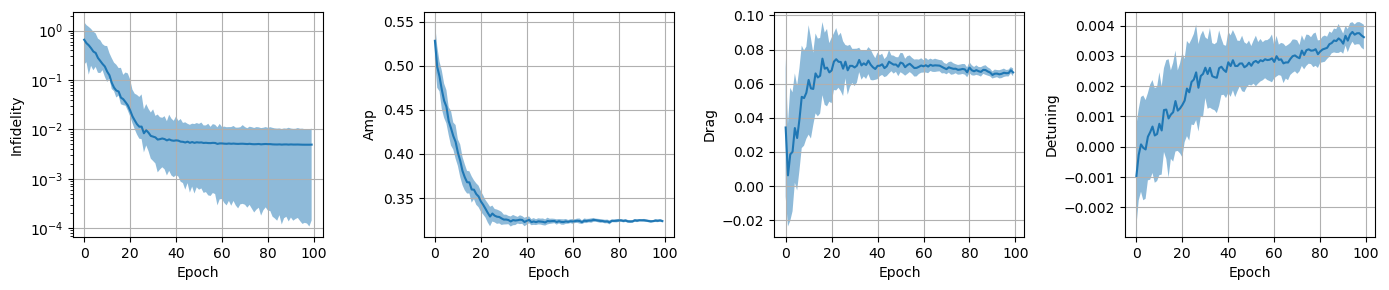

In [292]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))

ax[0].plot(epochs, mean_infidelity)
ax[0].fill_between(epochs, mean_infidelity-min_infidelity, mean_infidelity+max_infidelity, alpha = 0.5)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Infidelity')
ax[0].set_yscale('log')
ax[0].grid(True)

ax[1].plot(epochs, mean_amp)
ax[1].fill_between(epochs, mean_amp-stdev_amp, mean_amp+stdev_amp, alpha = 0.5)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Amp')
ax[1].grid(True)

ax[2].plot(epochs, mean_drag)
ax[2].fill_between(epochs, mean_drag-stdev_drag, mean_drag+stdev_drag, alpha = 0.5)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Drag') 
ax[2].grid(True)

ax[3].plot(epochs, mean_detuning)
ax[3].fill_between(epochs, mean_detuning-stdev_detuning, mean_detuning+stdev_detuning, alpha = 0.5)
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Detuning')
ax[3].grid(True)

fig.tight_layout()
plt.show()

Learned params : (amp, drag, det) :  (0.3236945, 0.066596, 0.0036169002)


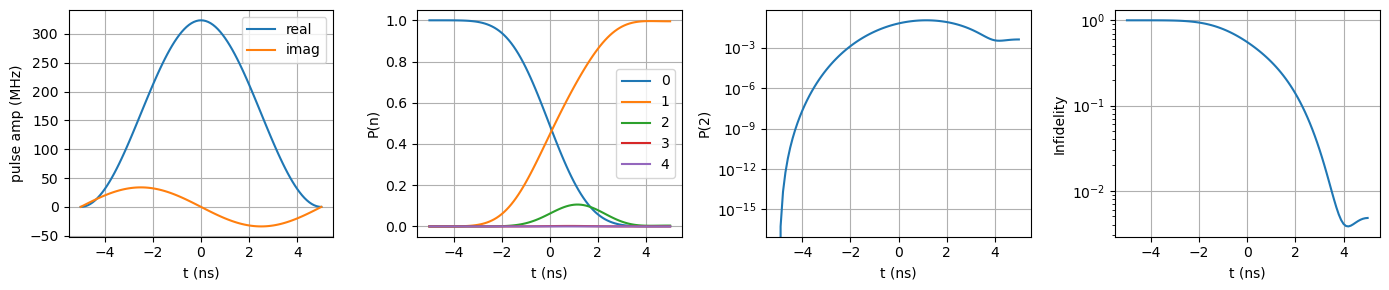

In [299]:
# Now test the pulse for the final learned params
print('Learned params : (amp, drag, det) : ', (mean_amp[-1], mean_drag[-1], mean_detuning[-1]))
N        = 5
t_pulse  = 10
n_times  = 101
kerr     = -0.1
res, rew = pi_pulse_sim(mean_amp[-1], 
                        mean_drag[-1], 
                        mean_detuning[-1], 
                        t_pulse = t_pulse, 
                        N = N       , 
                        kerr = kerr , 
                        n_times = n_times
                        )




fig, ax = plt.subplots(1, 4, figsize=(14, 3))

args    = {'t_pulse':t_pulse, 'amp':mean_amp[-1], 'drag':mean_drag[-1], 'detuning':mean_detuning[-1], 'kerr':kerr}
ax[0].plot(res.times,np.real(H1_coeff(res.times, args))*1e3,label='real')
ax[0].plot(res.times,np.imag(H1_coeff(res.times, args))*1e3,label='imag')
ax[0].set_xlabel('t (ns)')
ax[0].set_ylabel('pulse amp (MHz)')
ax[0].legend()
ax[0].legend()
ax[0].grid(True)

probs   = np.zeros((N,n_times),dtype=float)
for ii in range(N):
    for jj in range(n_times):
        probs[ii,jj] = qt.expect(qt.fock_dm(N,ii),res.states[jj])

    ax[1].plot(res.times,probs[ii],label=str(ii))
ax[1].set_xlabel('t (ns)')
ax[1].set_ylabel('P(n)')
ax[1].legend()
ax[1].grid(True)


ax[2].plot(res.times,probs[2])
ax[2].set_xlabel('t (ns)')
ax[2].set_ylabel('P(2)')
ax[2].set_yscale('log')
ax[2].grid(True)


ax[3].plot(res.times,1-probs[1])
ax[3].set_xlabel('t (ns)')
ax[3].set_ylabel('Infidelity')
ax[3].set_yscale('log')
ax[3].grid(True)

fig.tight_layout()
plt.show()